# The Study of Implicit Bias in Machine Learning
CS 760: Machine Learning final project (Fall 2020)

Bella Bai, Liu Yang, Xinyi Yu

## Preparation for experiments
We will load packages and data in this section.

In [1]:
#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))

# Any results  written to the current directory are saved as output.

Python version: 3.7.5 (v3.7.5:5c02a39a0b, Oct 14 2019, 18:49:57) 
[Clang 6.0 (clang-600.0.57)]
pandas version: 1.0.3
matplotlib version: 3.2.1
NumPy version: 1.18.5
SciPy version: 1.5.4
IPython version: 7.19.0
scikit-learn version: 0.23.2
-------------------------
propublica-violent-recidivism.csv



In [2]:
#Common Model Algorithms
from sklearn import tree, linear_model, neighbors, naive_bayes, ensemble

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

# Configure Visualization Defaults
# %matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [3]:
#import data from file
data_raw = pd.read_csv('./input/propublica-violent-recidivism.csv')

#to play with our data we'll create a copy
data1 = data_raw.copy(deep = True)

#however passing by reference is convenient, because we can clean both datasets at once
data_cleaner = [data1]

## Preprocessing
In this section, we preprocess the data, namely:
- select the needed features for training and testing
- complete the missing or invalid value in the dataset
- encode the feature with one-hot vector

In [4]:
# Select features needed for training
features = [
    'sex',
    'age_cat',
    'race',
    'juv_fel_count',
    'decile_score',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    'c_charge_degree',
    'is_recid',
    'score_text',
    'v_score_text',
    'two_year_recid'
]
data1 = data1[features]

In [5]:
# Compte or delete missing values in the data
data1['score_text'].fillna(data1['score_text'].mode()[0], inplace = True)
assert data1.isnull().sum().all() == 0, "There should be no NAN value in the data"

In [6]:
# Encode the data using one-hot.
data_dummy = pd.get_dummies(data1, prefix=['sex', 'age_cat', 'race', 'c_charge_degree', 'score_text', 'v_score_text'])

In [7]:
# CONVERT: convert objects to category using Label Encoder for train and test/validation dataset

#code categorical data
label = LabelEncoder()
# label encoder mark the sample according to its order:
# for example: LabelEncoder.fit_transform([1, 1, 100, 67, 5]) will get ([0, 0, 3, 2, 1])

# Sex: Male, Female => 0, 1
data1['sex_code'] = label.fit_transform(data1['sex'])
# age_cat (age category): 'Greater than 45', '25 - 45', 'Less than 25' => 1, 0, 2
data1['age_cat_code'] = label.fit_transform(data1['age_cat'])
# race: 'Other', 'African-American', 'Caucasian', 'Hispanic', 'Asian', 'Native American
data1['race_code'] = label.fit_transform(data1['race'])
# c_charge_degree: 'F', 'M'
data1['c_charge_degree_code'] = label.fit_transform(data1['c_charge_degree'])
data1['score_text_code'] = label.fit_transform(data1['score_text'])
data1['v_score_text_code'] = label.fit_transform(data1['v_score_text'])

#define y variable aka target/outcome
Target = ['two_year_recid']

#define x variables for original features aka feature selection
data1_x = features[:-1]
data1_x_calc = [
    'sex_code',
    'age_cat_code',
    'race_code',
    'juv_fel_count',
    'decile_score',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    'c_charge_degree_code',
    'is_recid',
    'score_text_code', 
    'v_score_text_code',
] 
data1_xy =  Target + data1_x
#define x variables for dummied features aka real feature selection
features_dummied = list(data_dummy.columns)
data1_x_dummied = list(data_dummy.columns)
data1_x_dummied.remove('two_year_recid')
data1_x_cal_dummied = data1_x_dummied
data1_xy_dummied = Target + data1_x_dummied

In [8]:
# split the train and test dataset
# train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], test_size=0.25, random_state = 0)
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data_dummy[data1_x_cal_dummied], data_dummy[Target], test_size=0.25, random_state = 0)

# get the corresponding raw dataset for later use
train1_x_raw, test1_x_raw, train1_y_raw, test1_y_raw = model_selection.train_test_split(data1, data1[Target], test_size=0.25, random_state = 0)
print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))
train1_x.head()

Data1 Shape: (4743, 19)
Train1 Shape: (3557, 25)
Test1 Shape: (1186, 25)


,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,...,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,score_text_High,score_text_Low,score_text_Medium,v_score_text_High,v_score_text_Low,v_score_text_Medium
2310,0,3,0,0,5,0,0,1,1,0,...,0,0,1,0,0,1,0,0,1,0
527,0,7,0,0,3,0,1,0,1,0,...,0,0,1,0,0,0,1,0,1,0
2948,0,2,0,0,1,0,0,1,0,1,...,0,0,0,1,0,1,0,0,1,0
2666,0,6,0,0,6,0,0,1,1,0,...,0,0,0,1,0,0,1,0,0,1
3862,0,4,0,0,1,1,0,1,1,0,...,0,0,1,0,0,1,0,0,0,1


## Observation on the data
In this section, we observe the data property.

In [9]:
#Discrete Variable Correlation by Survival using
#group by aka pivot table
for x in data1_x:
    if data1[x].dtype != 'float64' :
        print('two_year_recid Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')

two_year_recid Correlation by: sex
      sex  two_year_recid
0  Female        0.098295
1    Male        0.180726
---------- 

two_year_recid Correlation by: age_cat
           age_cat  two_year_recid
0          25 - 45        0.177103
1  Greater than 45        0.074423
2     Less than 25        0.240000
---------- 

two_year_recid Correlation by: race
               race  two_year_recid
0  African-American        0.207855
1             Asian        0.148148
2         Caucasian        0.122869
3          Hispanic        0.115721
4   Native American        0.272727
5             Other        0.125000
---------- 

two_year_recid Correlation by: juv_fel_count
   juv_fel_count  two_year_recid
0              0        0.156081
1              1        0.440860
2              2        0.318182
3              3        0.166667
4              4        0.250000
5              5        1.000000
6              6        1.000000
7              8        1.000000
8             20        1.000000
------

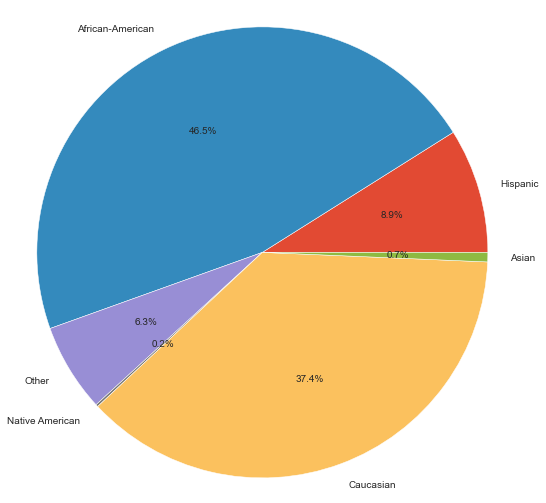

In [10]:
# observe the percentage of each group in race feature
sensitive = test1_x_raw["race"]  # only look at sample of feature "race"
sensitive_values = list(set(sensitive))
# the list is ['Other', 'Hispanic', 'African-American', 'Asian', 'Native American', 'Caucasian']
counting = []
name = []
for sens in sensitive_values:
    idx = sensitive == sens
    n_g = idx.sum()
    counting.append(n_g)
    name.append(sens)

plt.figure(figsize=[9,9])
plt.pie(counting,labels=name,autopct='%1.1f%%')
plt.axis('equal')
plt.savefig("pie_chart_race.pdf", bbox_inches='tight')

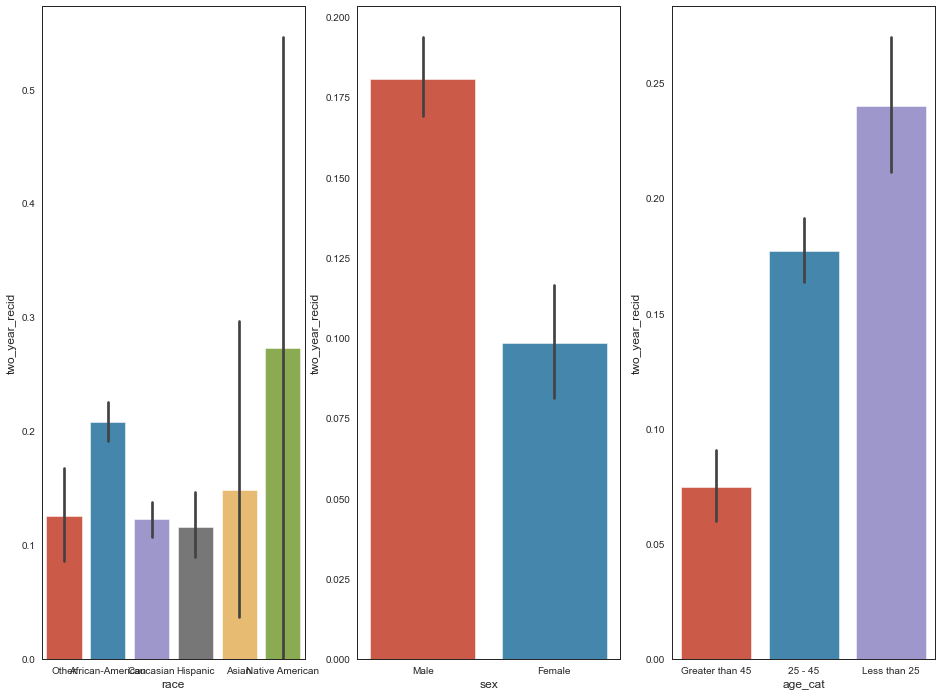

In [11]:
fig, (axis1,axis2,axis3) = plt.subplots(1, 3,figsize=(16,12))

sns.barplot(x = 'race', y = 'two_year_recid', data=data1, ax = axis1)
sns.barplot(x = 'sex', y = 'two_year_recid',  data=data1, ax = axis2)
sns.barplot(x = 'age_cat', y = 'two_year_recid', data=data1, ax = axis3)
plt.show()

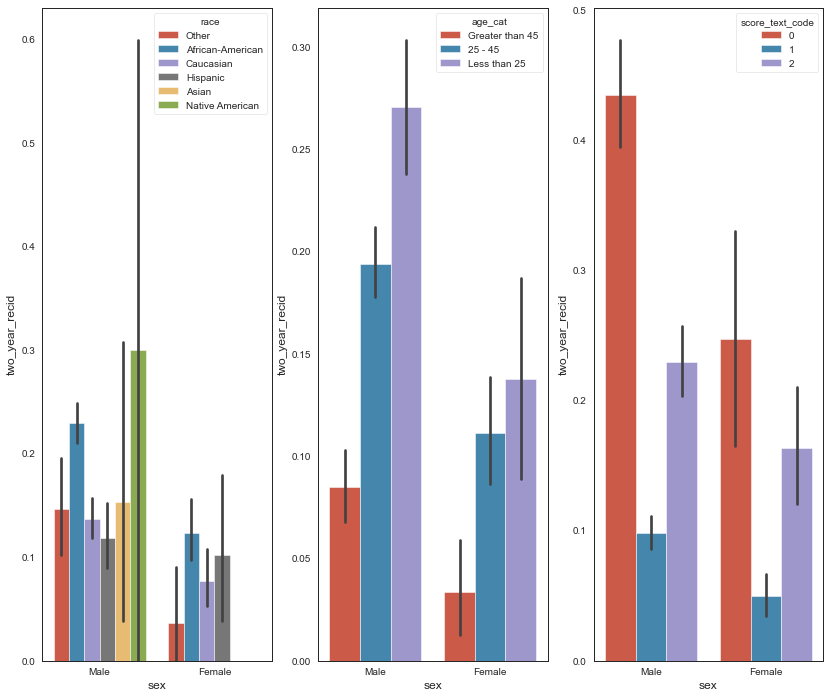

In [12]:
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'sex', y = 'two_year_recid', hue = 'race', data=data1, ax = qaxis[0])
axis1.set_title('sex vs race two_year_recid Comparison')

sns.barplot(x = 'sex', y = 'two_year_recid', hue = 'age_cat', data=data1, ax  = qaxis[1])
axis1.set_title('sex vs age_cat two_year_recid Comparison')

sns.barplot(x = 'sex', y = 'two_year_recid', hue = 'score_text_code', data=data1, ax  = qaxis[2])
axis1.set_title('sex vs score_text_code two_year_recid Comparison')
plt.show()

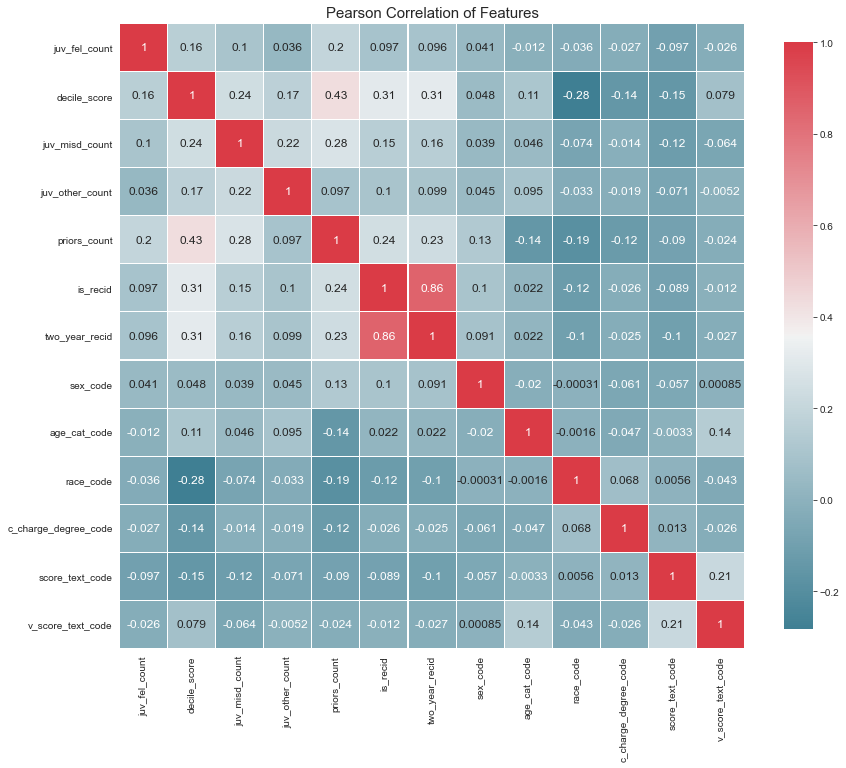

In [13]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

## Basic Machine Learning Algorithms
In this section, we train and compare the basic machine learning algorithms include:
- Random Forest
- Logistic Regression
- Bernoulli Naive Bayes
- Gaussian Naive Bayes
- k Nearest Neighborhood
- Decision Tree

In [14]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # ensembles
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(), # prior is bernoulli
    naive_bayes.GaussianNB(),  # prior is gaussian
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #Trees    
    tree.DecisionTreeClassifier()  
    ]

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']

#create table to compare MLA predictions
MLA_predict = test1_y[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    
    #score model with cross validation
    alg.fit(train1_x, train1_y)
    MLA_predict[MLA_name] = alg.predict(test1_x) #alg.predict(data1[data1_x_calc])


[[99  5]
 [ 0  7]]
[[316  19]
 [ 13  94]]


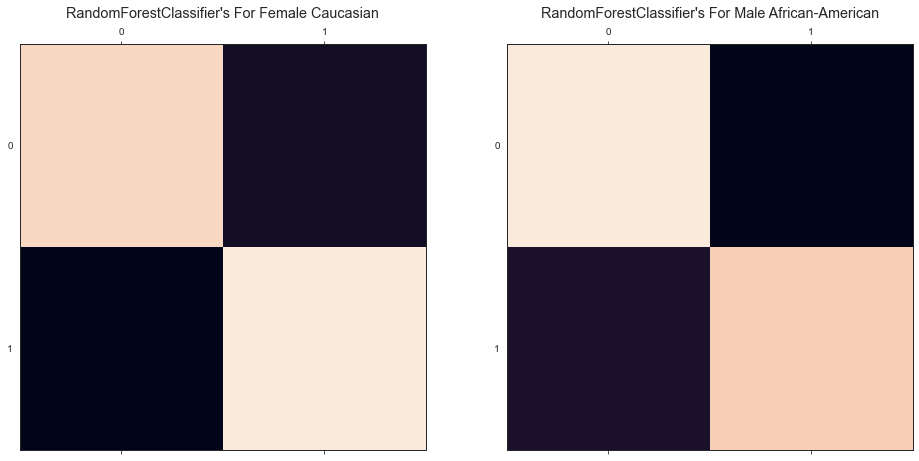

[[99  5]
 [ 0  7]]
[[309  26]
 [  0 107]]


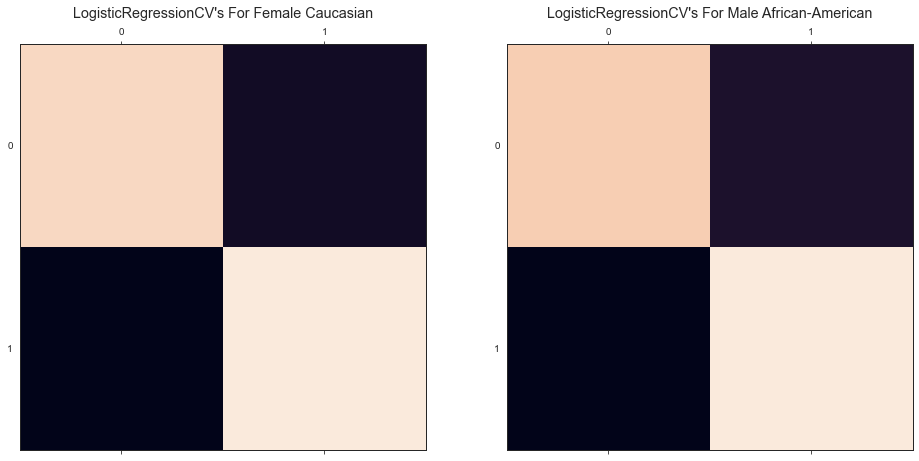

[[104   0]
 [  3   4]]
[[313  22]
 [  7 100]]


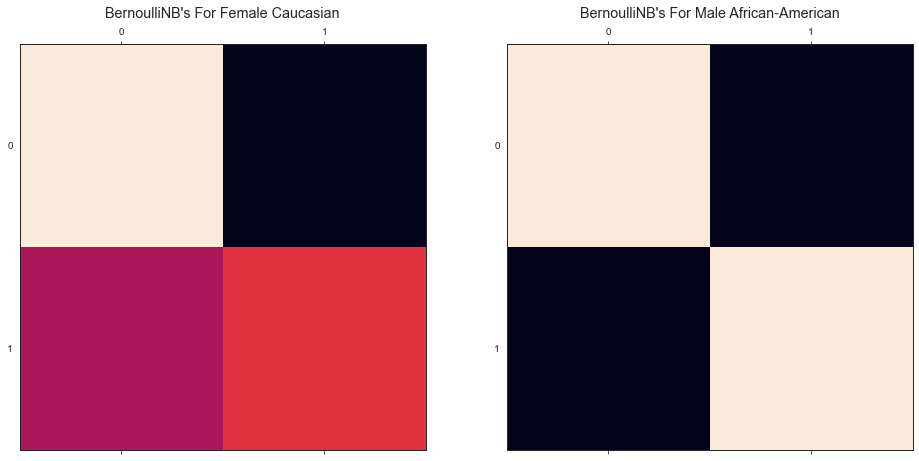

[[99  5]
 [ 1  6]]
[[309  26]
 [  0 107]]


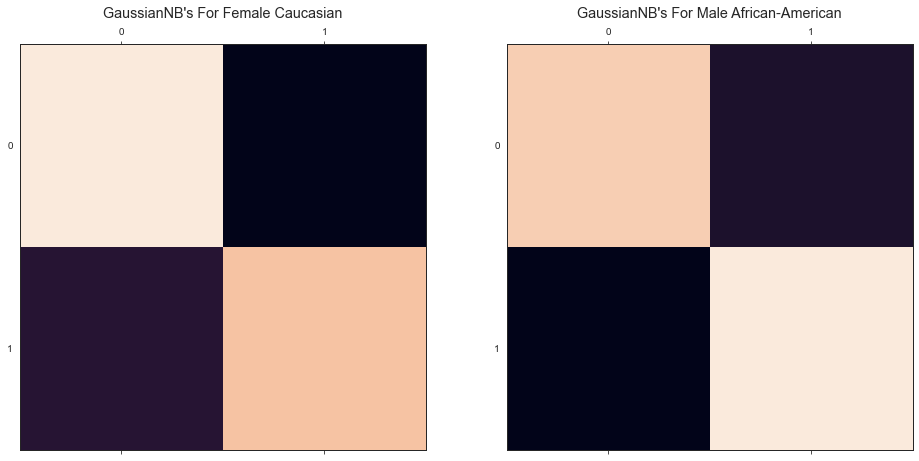

[[104   0]
 [  5   2]]
[[320  15]
 [ 58  49]]


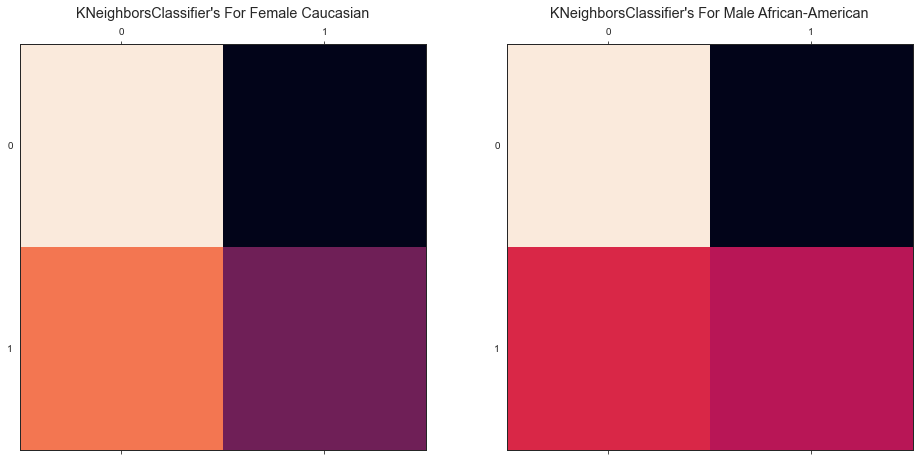

[[99  5]
 [ 0  7]]
[[318  17]
 [ 21  86]]


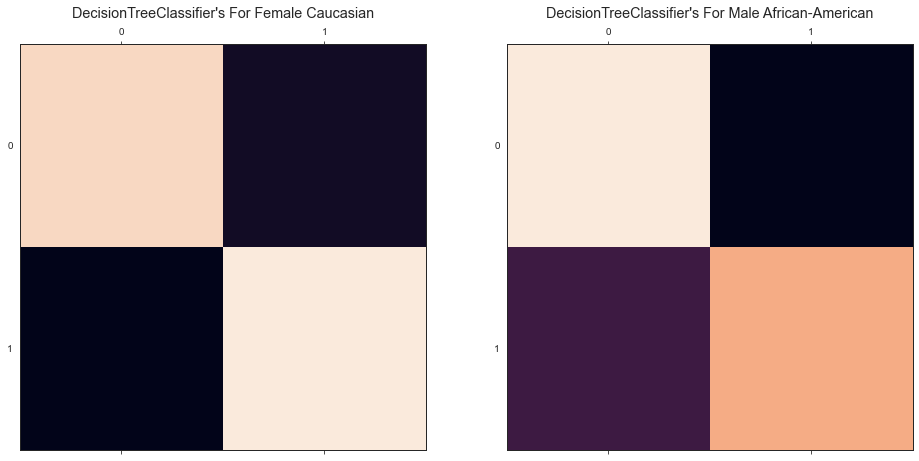

In [15]:
# pick candidate model to analysis its confusion matrix under two subgroups:
from sklearn.metrics import confusion_matrix
# caucassian women
data2 = test1_x_raw[(test1_x_raw['sex'] == 'Female') & (test1_x_raw['race'] == 'Caucasian')]
actual2 = data2[Target]
# african_america men
data3 = test1_x_raw[(test1_x_raw['sex'] == 'Male') & (test1_x_raw['race'] == 'African-American')]
actual3 = data3[Target]

for alg in MLA:
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(16,12))
    pred = MLA_predict[alg.__class__.__name__].copy()
    pred = pred.loc[actual2.index.intersection(pred.index)]
    conf_mat = confusion_matrix(actual2, pred)
    print(conf_mat)
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
#     ax = fig.add_subplot(211)
    cax = ax1.matshow(conf_mat, interpolation='nearest')
#     fig.colorbar(cax)
    ax1.set_title(alg.__class__.__name__ + '\'s For Female Caucasian')

    pred = MLA_predict[alg.__class__.__name__].copy()
    pred = pred.loc[actual3.index.intersection(pred.index)]
#     plt.subplot(1, 10, MLA.index(alg) + 1)
    conf_mat = confusion_matrix(actual3, pred)
    print(conf_mat)
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
#     ax = fig.add_subplot(212)
    cax = ax2.matshow(conf_mat, interpolation='nearest')
#     fig.colorbar(cax)
    ax2.set_title(alg.__class__.__name__ + '\'s For Male African-American')
    plt.show()


## Different Metric Measurements
We will include measurements of the following:
- accuracy
- equal opportunity
- disparate impact (DI) score
- generalized entropy index (alpha = 2)

In [16]:
from metrics import *

obj = metrics(data=test1_x_raw, prediction=MLA_predict)

# plot figure
def plot_figure(score_dict, score_name, ylim=[0, 1]):
    name_dict = {'RandomForestClassifier': 'RandomForest',
     'LogisticRegressionCV': 'Logistic',
     'BernoulliNB': "BernoulliNB",
     'GaussianNB': "GaussianNB",
     'KNeighborsClassifier': "KNN",
     'DecisionTreeClassifier': "DT"
    }
    score_list = []
    name_list = []
    # obj.algs is the list of algorithm we measure
    for alg in obj.algs:
        score_list.append(score_dict[alg])
        name_list.append(name_dict[alg])

    pylab.rcParams['figure.figsize'] = 12,6
    sns.barplot(x=name_list, y=score_list, palette="Blues_d")
    sns.set(font_scale = 3)
    plt.title(score_name)
    plt.ylim(ylim)
    plt.xticks(rotation=90)
    plt.savefig("baseline_{}.pdf".format(score_name), bbox_inches='tight')
    
acc_score = obj.get_accuracy()
equal_score = obj.get_equality_opportunity()
DI_score = obj.get_DI_score()
GEI_score = obj.get_generalized_entropy_index()
GEI_within_score = obj.get_generalized_entropy_index_within_group()
GEI_between_score = obj.get_generalized_entropy_index_between_group()

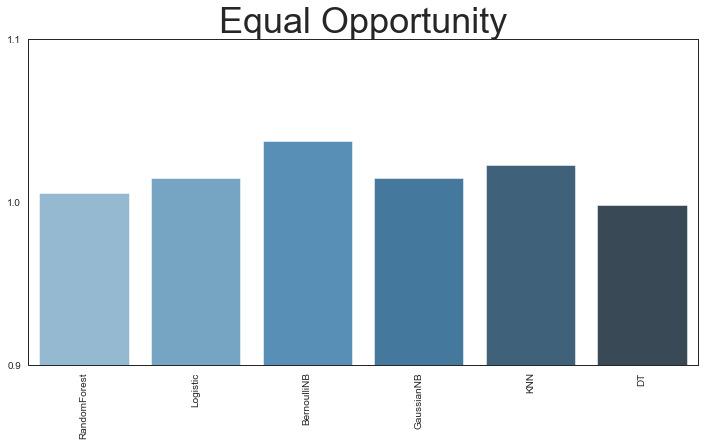

In [17]:
plot_figure(equal_score, "Equal Opportunity", [0.9, 1.1])

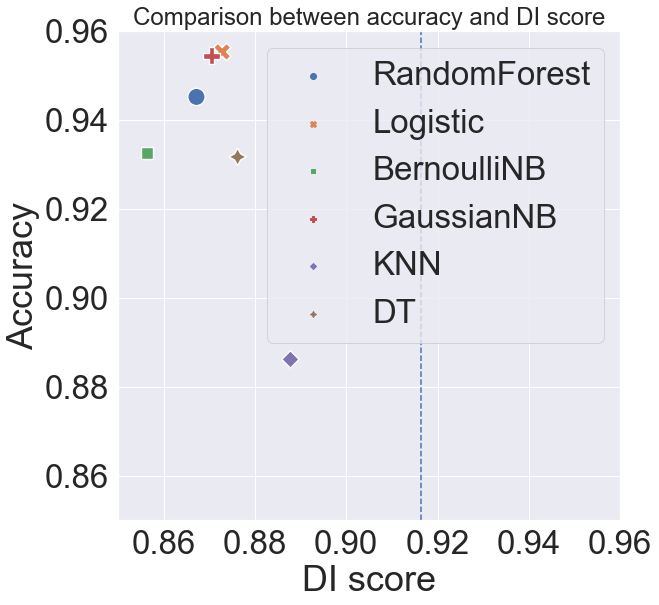

In [18]:
def plot_acc_di_figure(acc_dict, di_dict, threshold, name):
    name_dict = {'RandomForestClassifier': 'RandomForest',
     'LogisticRegressionCV': 'Logistic',
     'BernoulliNB': "BernoulliNB",
     'GaussianNB': "GaussianNB",
     'KNeighborsClassifier': "KNN",
     'DecisionTreeClassifier': "DT"
    }
    acc_list = []
    di_list = []
    name_list = []
    # obj.algs is the list of algorithm we measure
    for alg in obj.algs:
        acc_list.append(acc_dict[alg])
        di_list.append(di_dict[alg])
        name_list.append(name_dict[alg])

    pylab.rcParams['figure.figsize'] = 9,9
    sns.scatterplot(x=di_list, y=acc_list, hue=name_list, style=name_list, s=300)
    sns.set(font_scale = 2)
    plt.xlabel("DI score")
    plt.ylabel("Accuracy")
    plt.ylim([0.85, 0.96])
    plt.xlim([0.85, 0.96])
    plt.axvline(x=threshold, ls='--', c='b')
    plt.title(name)
    plt.savefig("baseline_{}.pdf".format(name), bbox_inches='tight')

# calculate the data property
S_1 = test1_x_raw[test1_x_raw['race'] == 'Caucasian']
S_1_Y_1 = S_1[S_1['two_year_recid'] == 0]
S_not_1 = test1_x_raw[test1_x_raw['race'] != 'Caucasian']
S_not_1_Y_1 = S_not_1[S_not_1['two_year_recid'] == 0]
threshold = (S_1.shape[0] * S_not_1_Y_1.shape[0]) / (S_1_Y_1.shape[0] * S_not_1.shape[0])
    
plot_acc_di_figure(acc_score, DI_score, threshold, "Comparison between accuracy and DI score")

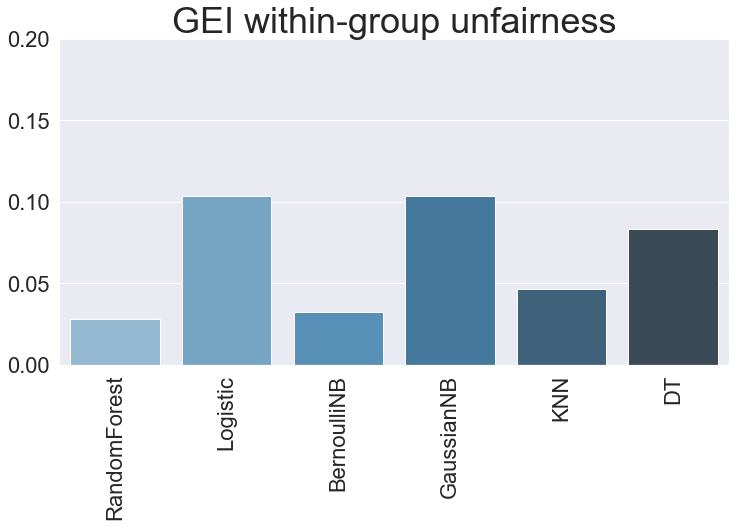

In [19]:
plot_figure(GEI_within_score, "GEI within-group unfairness", [0.0, 0.2])

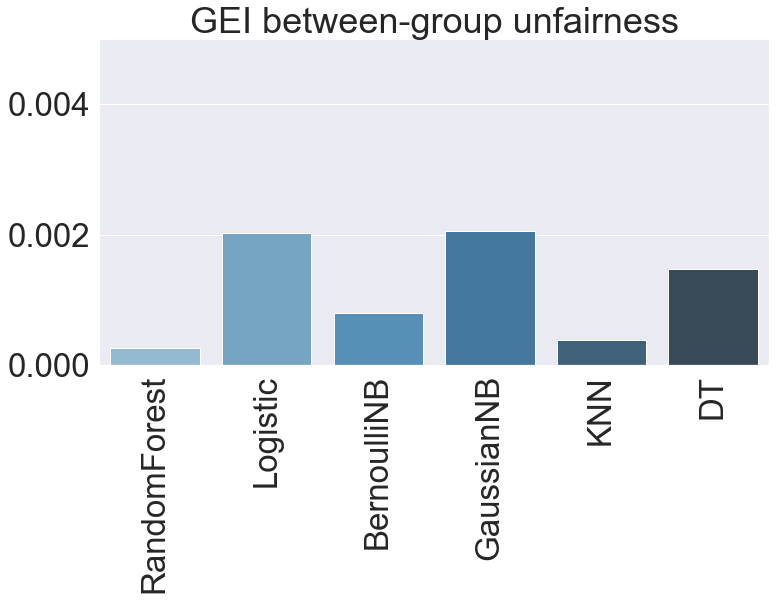

In [20]:
plot_figure(GEI_between_score, "GEI between-group unfairness", [0.0, 0.005])

## Fairness Enhancing Methods
In the following, we will apply the fairness enhancing methods:
- preprocessing: Feldman et al.
- inprocessing: meta classifier
- postprocessing: calibration

In [22]:
"""
References:
    .. [1] M. Feldman, S. A. Friedler, J. Moeller, C. Scheidegger, and
       S. Venkatasubramanian, "Certifying and removing disparate impact."
       ACM SIGKDD International Conference on Knowledge Discovery and Data
       Mining, 2015.
"""
# Run Feldman to repair our data set: repaired feature = sex, race
from BlackBoxAuditing.repairers.GeneralRepairer import Repairer
all_data = data1.values.tolist()
feature_list = data1.keys().to_list()
feature_to_repair = feature_list.index('race')
repairer = Repairer(all_data, feature_to_repair, 1.0, False)
repaired_data = repairer.repair(all_data)

In [23]:
# convert repaired_data (list) ro df
repaired_df = pd.DataFrame(repaired_data, columns=feature_list)
repaired_df['two_year_recid'] = data1['two_year_recid']
print(repaired_df.sample(10))

         sex          age_cat              race  juv_fel_count  decile_score  \
4649    Male  Greater than 45  African-American              0             1   
2359    Male          25 - 45  African-American              0             9   
3017    Male          25 - 45  African-American              0             1   
2251    Male          25 - 45  African-American              0             4   
1322    Male          25 - 45  African-American              0             4   
3652    Male     Less than 25  African-American              0             4   
1656  Female  Greater than 45  African-American              0             1   
3985    Male          25 - 45  African-American              0             4   
4669    Male          25 - 45  African-American              0             4   
2374    Male          25 - 45  African-American              0             2   

      juv_misd_count  juv_other_count  priors_count c_charge_degree  is_recid  \
4649               0                0 

In [24]:
# one hot the reparied dataset and drop the generated labelEncoder one
repaired_df_dummy = pd.get_dummies(repaired_df, prefix=['sex', 'age_cat', 'race', 'c_charge_degree', 'score_text', 'v_score_text'])
repaired_x_cal_dummied  = repaired_df_dummy.columns.to_list()
removed_items = ['sex_code', 'age_cat_code', 'race_code', 'c_charge_degree_code', 'score_text_code', 'v_score_text_code' ,'two_year_recid']
for item in removed_items:
    repaired_x_cal_dummied.remove(item)



In [25]:
repaired_train1_x, repaired_test1_x, repaired_train1_y, repaired_test1_y = model_selection.train_test_split(repaired_df_dummy[repaired_x_cal_dummied], repaired_df_dummy[Target], test_size=0.25, random_state = 0)


In [26]:
repaired_train1_x_raw, repaired_test1_x_raw, repaired_train1_y_raw, repaired_test1_y_raw = model_selection.train_test_split(repaired_df, repaired_df[Target], test_size=0.25, random_state = 0)


In [27]:
#create table to compare MLA predictions after Feldman
MLA_predict_after = repaired_test1_y[Target]
#index through MLA and save performance to table
row_index = 0
for alg in MLA:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    #save MLA predictions - see section 6 for usage
    alg.fit(repaired_train1_x, train1_y)
    MLA_predict_after[MLA_name] = alg.predict(repaired_test1_x)#alg.predict(repaired_df[data1_x_calc])
    row_index+=1

In [29]:
# calculate the DIavgall
def calc(actual, predicted, dict_of_sensitive_lists, single_sensitive_name,
             unprotected_vals, positive_pred):
    """
    :param actual: label
    :param predicted: prediction
    :param dict_of_sensitive_lists: samples
    :param single_sensitive_name: focus on which feature, here is race
    :param unprotected_vals: ['African-American', 'Caucasian']
    :param positive_pred: 1, means that person has recid in two years
    """
    sensitive = dict_of_sensitive_lists[single_sensitive_name]  # only look at sample of feature "race"
    sensitive_values = list(set(sensitive))
    # the list is ['Other', 'Hispanic', 'African-American', 'Asian', 'Native American', 'Caucasian']
    
    if len(sensitive_values) <= 1:
        print("ERROR: Attempted to calculate DI without enough sensitive values:" + \
               str(sensitive_values))
        return 1.0

    # this list should only have one item in it
    what_is_this = [val for val in sensitive_values if val in unprotected_vals]
    # ['African-American', 'Caucasian']
    single_unprotected = [val for val in sensitive_values if val in unprotected_vals][0]
#     print(single_unprotected)
    # single_unprotected becomes only 'African-American'. Something wrong?
    unprotected_prob = calc_prob_class_given_sensitive(predicted, sensitive, positive_pred,
                                                       single_unprotected)

    sensitive_values.remove(single_unprotected)
    total = 0.0
    for sens in sensitive_values:
        pos_prob = calc_prob_class_given_sensitive(predicted, sensitive, positive_pred, sens)
        DI = 0.0
        if unprotected_prob > 0:
            DI = pos_prob / unprotected_prob
        if unprotected_prob == 0.0 and pos_prob == 0.0:
            DI = 1.0
        total += DI

    if total == 0.0:
         return 1.0

    return total / len(sensitive_values)


x_axis = ['RandomForest', 'Logistic', 'BernoulliNB', 'GaussianNB', 'KNN', 'DT']

DI_res_repaired = []
actual = repaired_test1_x_raw[Target]
dict_of_sensitive_lists = test1_x_raw
single_sensitive_name = 'race'
unprotected_vals = ['Caucasian']
positive_pred = 0
for alg in MLA:
    predicted = MLA_predict_after[alg.__class__.__name__]
    score = calc(actual, predicted, dict_of_sensitive_lists, single_sensitive_name, unprotected_vals, positive_pred)
    DI_res_repaired.append(score)
    print(alg.__class__.__name__ + "'s DI score': " + str(score))

    
DI_res = []
for alg in MLA:
    predicted = MLA_predict[alg.__class__.__name__]
    score = calc(actual, predicted, dict_of_sensitive_lists, single_sensitive_name, unprotected_vals, positive_pred)
    DI_res.append(score)
    print(alg.__class__.__name__ + "'s DI score': " + str(score))

RandomForestClassifier's DI score': 0.8988944186187829
LogisticRegressionCV's DI score': 0.8728320566308984
BernoulliNB's DI score': 0.865099187437662
GaussianNB's DI score': 0.8728320566308984
KNeighborsClassifier's DI score': 0.9786647838975163
DecisionTreeClassifier's DI score': 0.8730980566518604
RandomForestClassifier's DI score': 0.8671945822989781
LogisticRegressionCV's DI score': 0.8728320566308984
BernoulliNB's DI score': 0.8564277379994742
GaussianNB's DI score': 0.8704982810784095
KNeighborsClassifier's DI score': 0.8877815372520562
DecisionTreeClassifier's DI score': 0.8762075789661115


In [30]:
"""The meta algorithm here takes the fairness metric as part of the input
and returns a classifier optimized w.r.t. that fairness metric [11]_.
References:
    .. [11] L. E. Celis, L. Huang, V. Keswani, and N. K. Vishnoi.
       "Classification with Fairness Constraints: A Meta-Algorithm with
       Provable Guarantees," 2018.
"""
# run Meta Algorithm
# import the fairness metric to be used, here we use disparate impact, consistent with feldman above

from aif360.algorithms.inprocessing.celisMeta.StatisticalRate import StatisticalRate
tau = 0 # fairness penalty parameter
# find all race features after one hot
data_race = data1.copy(deep=True).race
data_race_cols =   pd.get_dummies(data_race).columns.to_list()
for i in range(len(data_race_cols)):
    data_race_cols[i] = 'race' + "_" + data_race_cols[i]
sens_indexs = []
for race in data_race_cols:
    sens_indexs.append(data1_x_cal_dummied.index(race))

x_train = train1_x.values
y_train = np.array([1 if y == 1 else
                           -1 for y in train1_y.values])
x_control_train = []
for i in range(len(x_train)):
    for sens_index in sens_indexs:
        x_control_train.append(x_train[i][sens_index])
# train the meta classifier
meta = StatisticalRate().getModel(tau, x_train, y_train, x_control_train)


In [31]:
meta_predictions = []
for entry in test1_x.values:
    t = meta(entry)
    meta_predictions.append(int(t > 0))
DI_res_meta = calc(actual, meta_predictions, dict_of_sensitive_lists, single_sensitive_name, unprotected_vals, positive_pred)
print("meta-classifier's DI score: " + str(DI_res_meta))


meta-classifier's DI score: 0.8728320566308984


In [32]:
cnt = 0
for i in range(len(test1_y.values)):
    if meta_predictions[i] != test1_y.values[i]:
        cnt += 1
meta_acc = 1 - cnt / len(meta_predictions)
print("meta-classifier's accuracy: " + str(meta_acc))

meta-classifier's accuracy: 0.9553119730185498


In [33]:
# post-processing: calibration
"""Calibrated equalized odds postprocessing is a post-processing technique
that optimizes over calibrated classifier score outputs to find
probabilities with which to change output labels with an equalized odds
objective [7]_.
References:
    .. [7] G. Pleiss, M. Raghavan, F. Wu, J. Kleinberg, and
       K. Q. Weinberger, "On Fairness and Calibration," Conference on Neural
       Information Processing Systems, 2017
Adapted from:
https://github.com/gpleiss/equalized_odds_and_calibration/blob/master/calib_eq_odds.py
"""
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing


priviledged = [{'race_Caucasian': 0}]
unpriviledged = [{'race_Caucasian': 1}]
calibration = CalibratedEqOddsPostprocessing(unpriviledged, priviledged)

from aif360.datasets.binary_label_dataset import BinaryLabelDataset

protected_attr_names = ['race_Other', 'race_Native American', 'race_Hispanic', 'race_Asian', 'race_Caucasian', 'race_African-American']
data_true = pd.concat([test1_x, test1_y], axis = 1)
dataset_true = BinaryLabelDataset(df=data_true, label_names=Target,
        protected_attribute_names=protected_attr_names)

cali_res = []
for alg in MLA:
    data_pred = pd.concat([test1_x, MLA_predict[alg.__class__.__name__]], axis = 1)
    data_pred.columns = data1_x_cal_dummied+Target
    dataset_pred = BinaryLabelDataset(df=data_pred, label_names=Target, protected_attribute_names=protected_attr_names)
    cali_res.append(calibration.fit_predict(dataset_true, dataset_pred))


In [35]:
# calculate DI score for calibration
DI_res_cali = []
for i in range(len(MLA)):
    predicted = cali_res[i].labels
    score = calc(actual, predicted, dict_of_sensitive_lists, single_sensitive_name, unprotected_vals, positive_pred)
    DI_res_cali.append(score)
    print(MLA[i].__class__.__name__ + "'s DI score': " + str(score))

RandomForestClassifier's DI score': 1.0
LogisticRegressionCV's DI score': 1.0
BernoulliNB's DI score': 1.0
GaussianNB's DI score': 1.0
KNeighborsClassifier's DI score': 1.0
DecisionTreeClassifier's DI score': 1.0


In [36]:
print("Calibration: ")
cali_acc = []
for j in range(len(cali_res)):
    cnt = 0
    for i in range(len(test1_y.values)):
        if test1_y.values[i] != cali_res[j].labels.tolist()[i]:
            cnt += 1
    acc = 1 - cnt / len(test1_y.values)
    cali_acc.append(acc)
    print(MLA[j].__class__.__name__ + "'s accuracy'" + str(acc))


Calibration: 
RandomForestClassifier's accuracy'0.9435075885328836
LogisticRegressionCV's accuracy'0.9536256323777403
BernoulliNB's accuracy'0.9291736930860034
GaussianNB's accuracy'0.954468802698145
KNeighborsClassifier's accuracy'0.8802698145025295
DecisionTreeClassifier's accuracy'0.9317032040472175


In [37]:
print("Baseline:")
base_acc = [0, 0, 0, 0, 0, 0]
for j in range(len(MLA)):
    for i in range(len(MLA_predict)):
        if test1_y.values[i] == MLA_predict[MLA[j].__class__.__name__].values[i]:
            base_acc[j] += 1
    base_acc[j] /= len(test1_y)
    print(MLA[j].__class__.__name__ + "'s accuracy'" + str(base_acc[j]))


Baseline:
RandomForestClassifier's accuracy'0.945193929173693
LogisticRegressionCV's accuracy'0.9553119730185498
BernoulliNB's accuracy'0.9325463743676222
GaussianNB's accuracy'0.954468802698145
KNeighborsClassifier's accuracy'0.8861720067453626
DecisionTreeClassifier's accuracy'0.9317032040472175


In [38]:
print("Feldman: ")
feldman_acc = [0, 0, 0, 0, 0, 0]
for j in range(len(MLA)):
    for i in range(len(MLA_predict_after)):
        if test1_y.values[i] == MLA_predict_after[MLA[j].__class__.__name__].values[i]:
            feldman_acc[j] += 1
    feldman_acc[j] /= len(test1_y)
    print(MLA[j].__class__.__name__ + "'s accuracy'" + str(base_acc[j]))


Feldman: 
RandomForestClassifier's accuracy'0.945193929173693
LogisticRegressionCV's accuracy'0.9553119730185498
BernoulliNB's accuracy'0.9325463743676222
GaussianNB's accuracy'0.954468802698145
KNeighborsClassifier's accuracy'0.8861720067453626
DecisionTreeClassifier's accuracy'0.9317032040472175


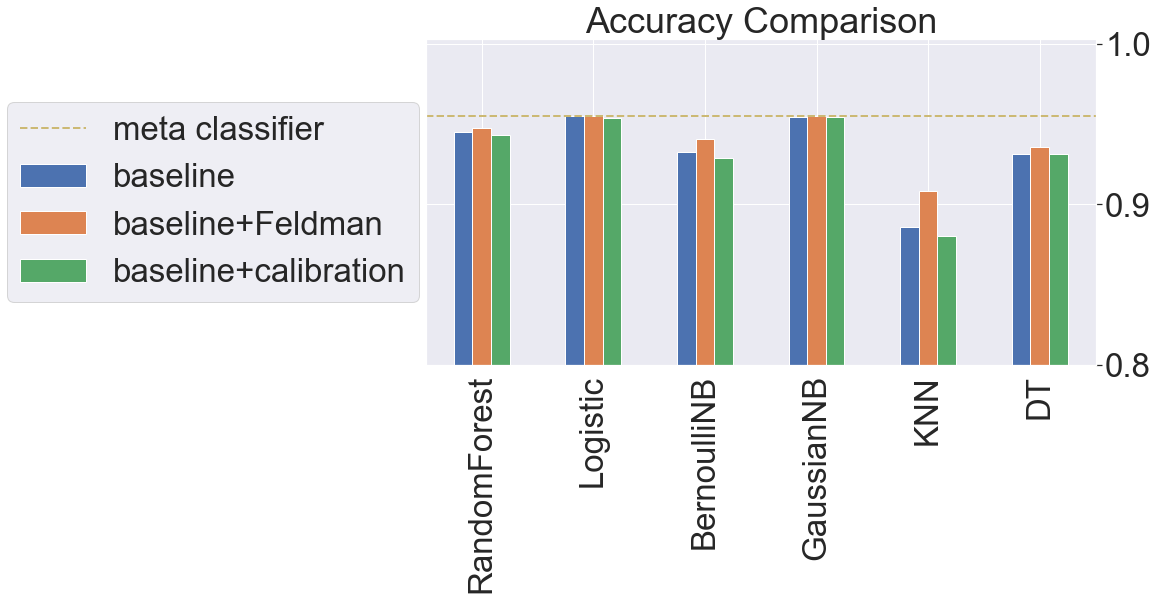

In [51]:
acc_cmp = pd.DataFrame(np.c_[base_acc, feldman_acc, cali_acc], index=x_axis)
ax = acc_cmp.plot.bar()
ax.axhline(y=meta_acc, color='y', linestyle='--', lw=2)
ax.legend(["meta classifier", "baseline", "baseline+Feldman", "baseline+calibration"], loc='center left',bbox_to_anchor=(-0.65, 0.5))
ax.axis(ymin=0.8)
ax.yaxis.tick_right()
plt.title("Accuracy Comparison")
plt.show()

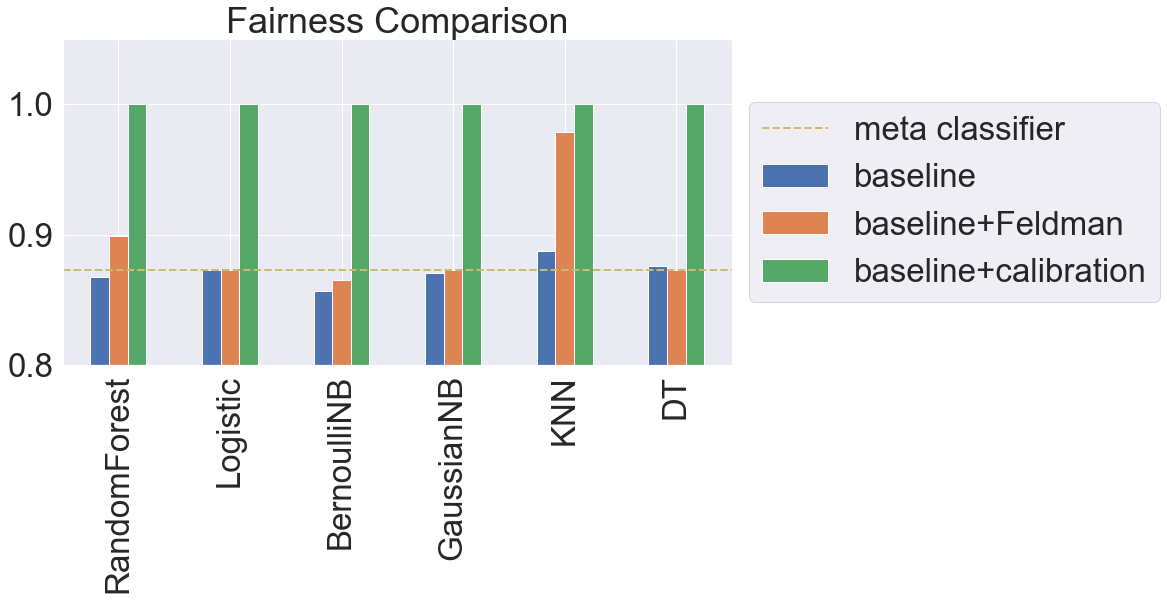

In [52]:
fair_cmp = pd.DataFrame(np.c_[DI_res, DI_res_repaired, DI_res_cali], index=x_axis)
ax = fair_cmp.plot.bar()
ax.axhline(y=DI_res_meta, color='y', linestyle='--', lw=2)
ax.legend(["meta classifier", "baseline", "baseline+Feldman", "baseline+calibration"], loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.axis(ymin=0.8)
plt.title("Fairness Comparison")
plt.show()

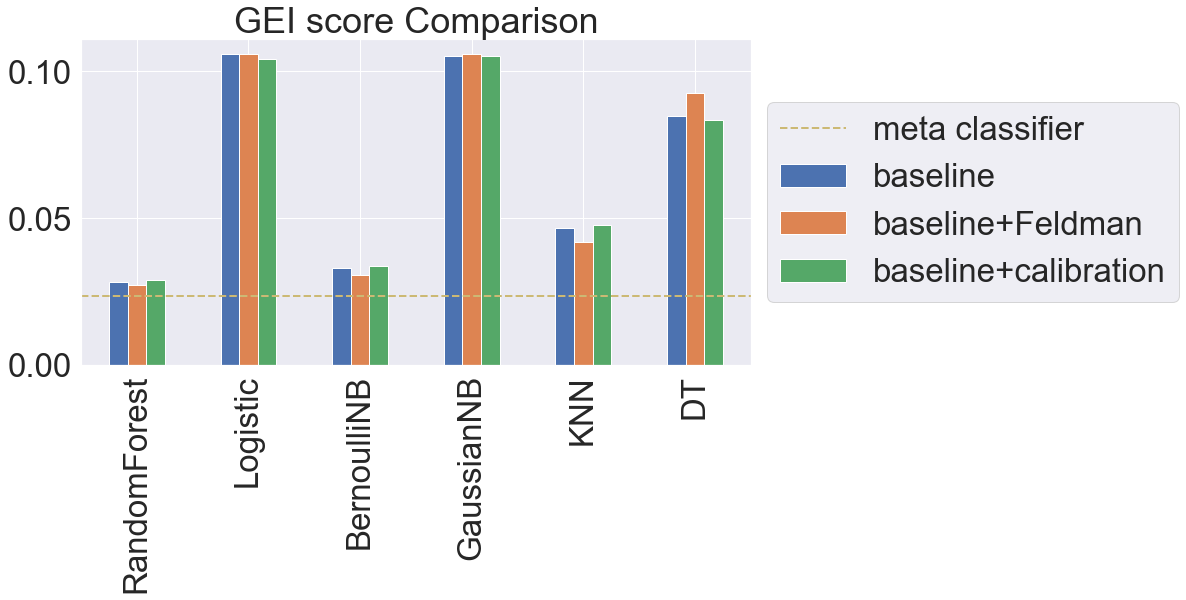

In [53]:
# GEI comparison
feldman_gei_obj = metrics(data=test1_x_raw, prediction=MLA_predict_after)
feldman_gei = feldman_gei_obj.get_generalized_entropy_index()
feldman_within = feldman_gei_obj.get_generalized_entropy_index_within_group()
feldman_between = feldman_gei_obj.get_generalized_entropy_index_between_group()

MLA_predict_cali = test1_y[Target]
for i in range(len(MLA)):
    MLA_predict_cali[MLA[i].__class__.__name__] = cali_res[i].labels
cali_gei_obj = metrics(data=test1_x_raw, prediction=MLA_predict_cali)
cali_gei = cali_gei_obj.get_generalized_entropy_index()
cali_within = cali_gei_obj.get_generalized_entropy_index_within_group()
cali_between = cali_gei_obj.get_generalized_entropy_index_between_group()

meta_pred_df = test1_y[Target]
meta_pred_df["meta classifier"] = meta_predictions
meta_gei_obj = metrics(data=test1_x_raw, prediction=meta_pred_df)
meta_gei = meta_gei_obj.get_generalized_entropy_index()
meta_within = meta_gei_obj.get_generalized_entropy_index_within_group()
meta_between = meta_gei_obj.get_generalized_entropy_index_between_group()

gei_cmp = pd.DataFrame(np.c_[list(GEI_score.values()), list(feldman_gei.values()), list(cali_gei.values())], index=x_axis)
ax = gei_cmp.plot.bar()
ax.axhline(y=meta_gei["meta classifier"], color='y', linestyle='--', lw=2)
ax.legend(["meta classifier", "baseline", "baseline+Feldman", "baseline+calibration"], loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.title("GEI score Comparison")
plt.show()


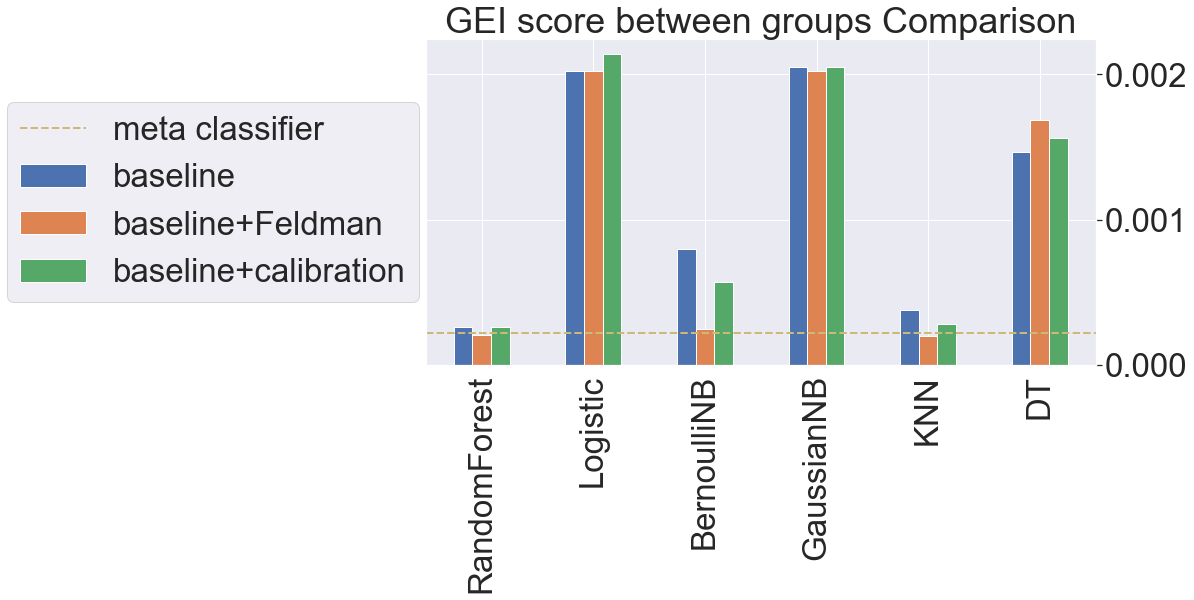

In [55]:
gei_between_cmp = pd.DataFrame(np.c_[list(GEI_between_score.values()), list(feldman_between.values()), list(cali_between.values())], index=x_axis)
ax = gei_between_cmp.plot.bar()
ax.axhline(y=meta_between["meta classifier"], color='y', linestyle='--', lw=2)
ax.legend(["meta classifier", "baseline", "baseline+Feldman", "baseline+calibration"], loc='center left',bbox_to_anchor=(-0.65, 0.5))
ax.yaxis.tick_right()
plt.title("GEI score between groups Comparison")
plt.show()


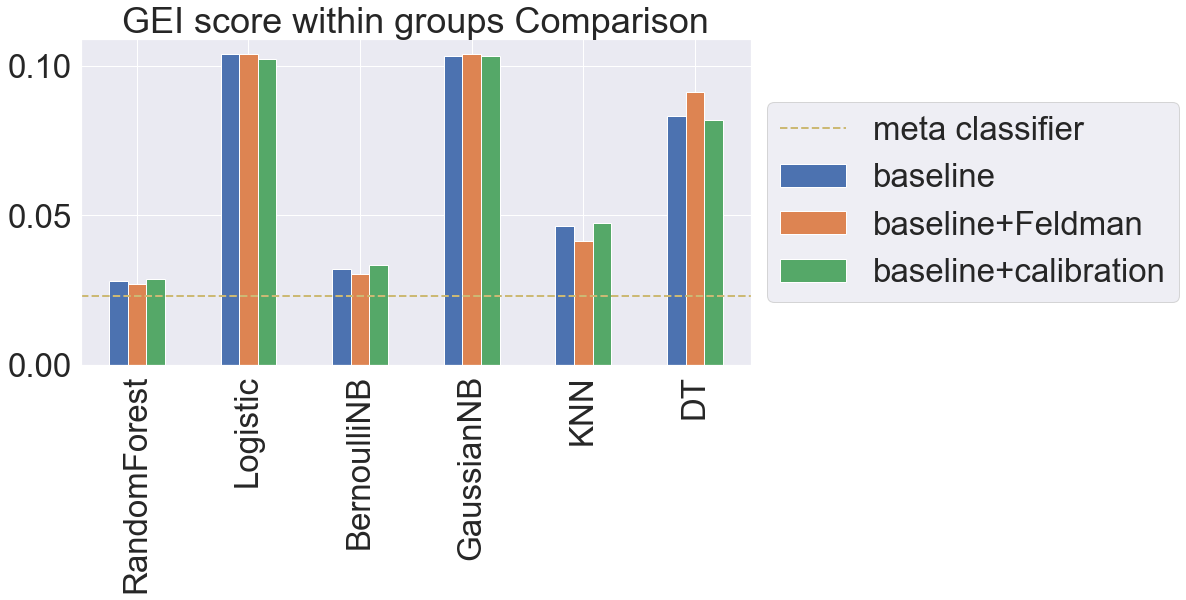

In [56]:
gei_within_cmp = pd.DataFrame(np.c_[list(GEI_within_score.values()), list(feldman_within.values()), list(cali_within.values())], index=x_axis)
ax = gei_within_cmp.plot.bar()
ax.axhline(y=meta_within["meta classifier"], color='y', linestyle='--', lw=2)
ax.legend(["meta classifier", "baseline", "baseline+Feldman", "baseline+calibration"], loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.title("GEI score within groups Comparison")
plt.show()
